In [1]:
from chromo import models as im
from chromo.kinematics import CenterOfMass
from chromo.constants import GeV
from chromo.util import get_all_models

# from util import run_in_separate_process
from particle import literals as lp
import numpy as np
from matplotlib import pyplot as plt
import joblib

In [2]:
energies = np.geomspace(10, 100000, 20) * GeV


@joblib.delayed
def run(Model):
    values = []
    m = Model(CenterOfMass(energies[-1], "p", "p"))
    for en in energies:
        kin = CenterOfMass(en, "p", "p")
        c = m.cross_section(kin)
        values.append(c)
    return values


Models = [
    M
    for M in get_all_models()
    if lp.proton.pdgid in M.projectiles and lp.proton.pdgid in M.targets
]
cross_sections = {}
out = joblib.Parallel(len(Models), batch_size=1)(run(Model) for Model in Models)
for Model, o in zip(Models, out):
    cross_sections[Model.pyname] = o

 +-----------------------------------------------------------------------+
 |                                                                       |
 |                       DPMJET-III version 19.3.5                       |
 |                                                                       |
 |                      (Last change:  16 Jan 2023)                      |
 |                                                                       |
 |            Authors:                                                   |
 |                     Stefan Roesler     (CERN)                         |
 |                     Anatoli Fedynitch (ASIoP)                         |
 |                     Ralph Engel        (KIT)                          |
 |                     Johannes Ranft     (Siegen Univ.)                 |
 |                                                                       |
 |        https://github.com/afedynitch/dpmjet                           |
 |                       

/home/anatoli/devel_wsl/chromo/src/chromo/models/urqmd.py:203: RuntimeWarning: 13 unknown to UrQMD
  warnings.warn(f"{pdgid} unknown to UrQMD", RuntimeWarning)
/home/anatoli/devel_wsl/chromo/src/chromo/models/urqmd.py:203: RuntimeWarning: 130 unknown to UrQMD
  warnings.warn(f"{pdgid} unknown to UrQMD", RuntimeWarning)
/home/anatoli/devel_wsl/chromo/src/chromo/models/urqmd.py:203: RuntimeWarning: 310 unknown to UrQMD
  warnings.warn(f"{pdgid} unknown to UrQMD", RuntimeWarning)
/home/anatoli/devel_wsl/chromo/src/chromo/models/urqmd.py:203: RuntimeWarning: -13 unknown to UrQMD
  warnings.warn(f"{pdgid} unknown to UrQMD", RuntimeWarning)


        pT0 = 5.46 GeV gives sigma(parton-parton) = 4.46D+02 mb: accepted

 ********************** PYINIT: initialization completed **********************
1****************** PYINIT: initialization of PYTHIA routines *****************

 I                                                                            I
 I              PYTHIA will be initialized for a p on p collider              I
 I                  at    297.635 GeV center-of-mass energy                   I
 I                                                                            I

 ******** PYMAXI: summary of differential cross-section maximum search ********

           I                                      I                 I
           I  ISUB  Subprocess name               I  Maximum value  I
           I                                      I                 I
           I                                      I                 I
           I   92   Single diffractive (XB)       I    5.2323D+00   I
           I

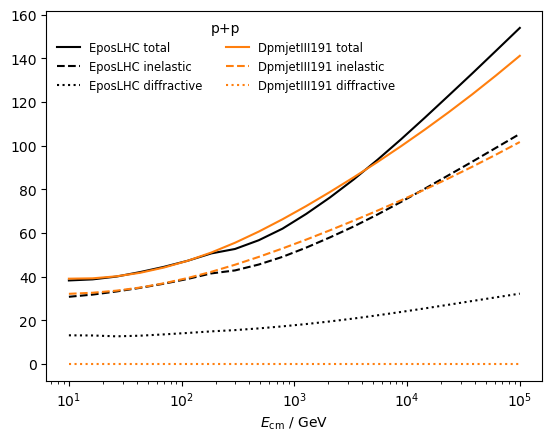

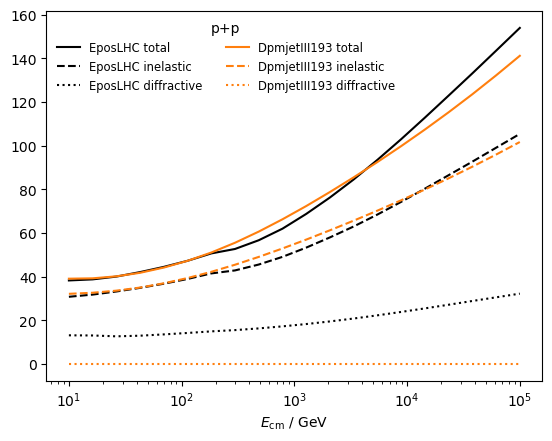

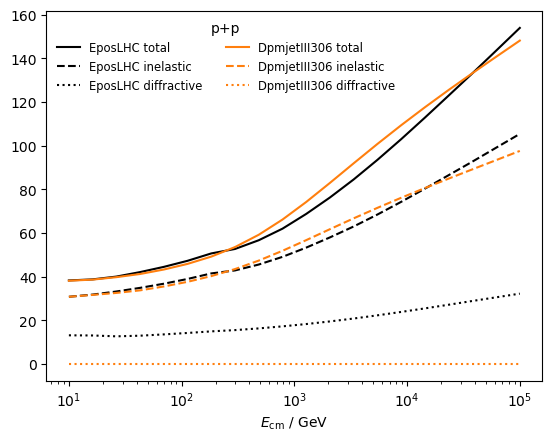

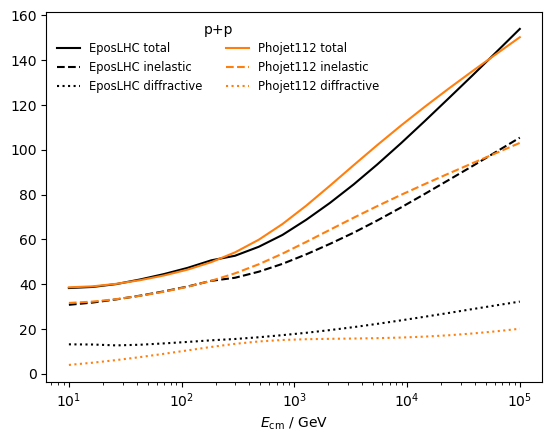

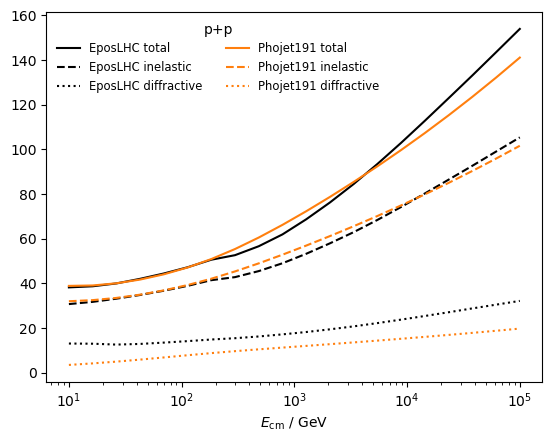

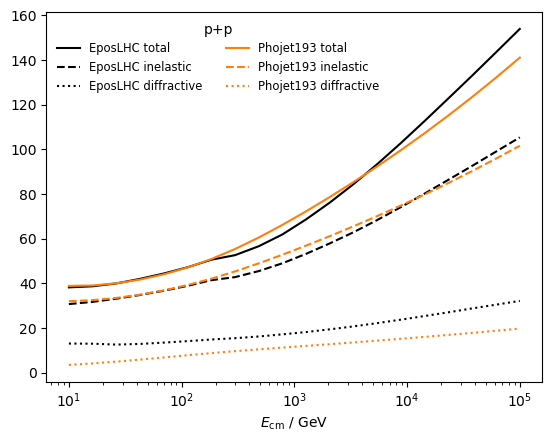

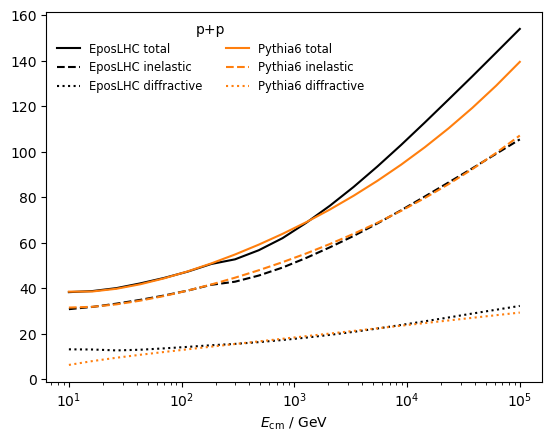

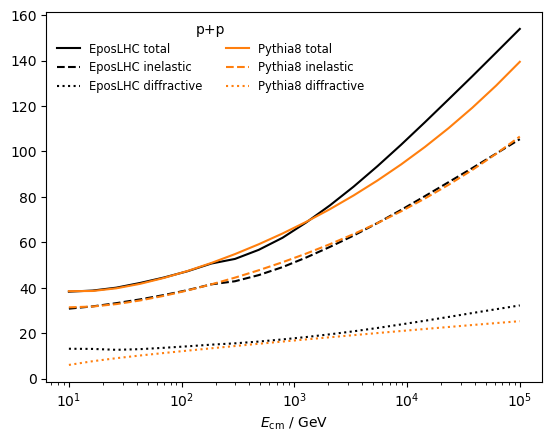

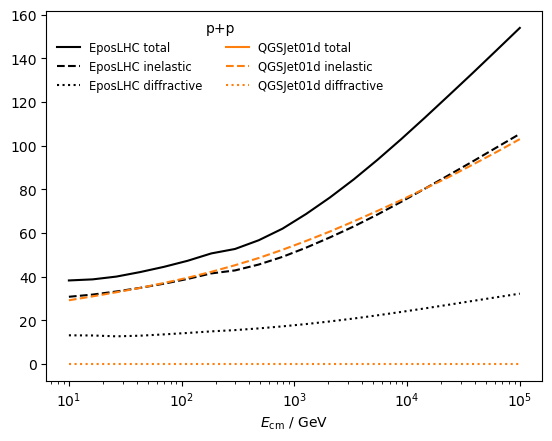

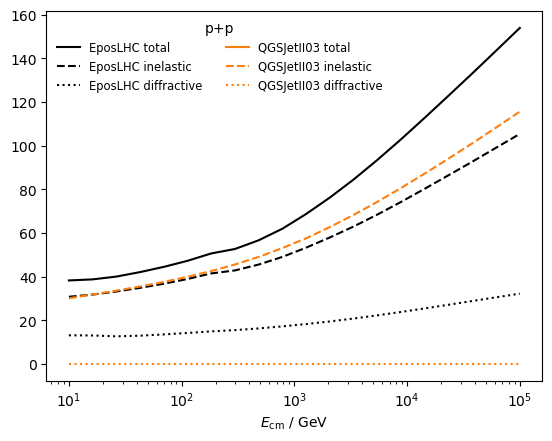

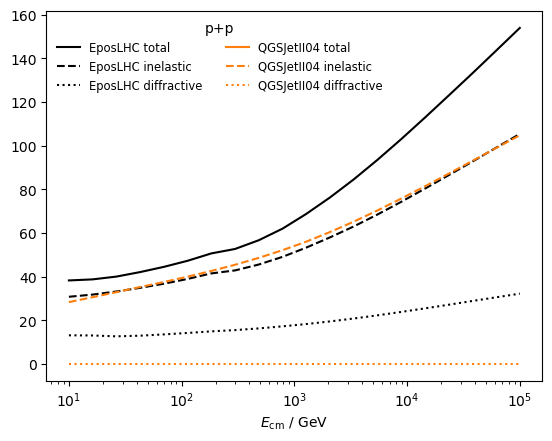

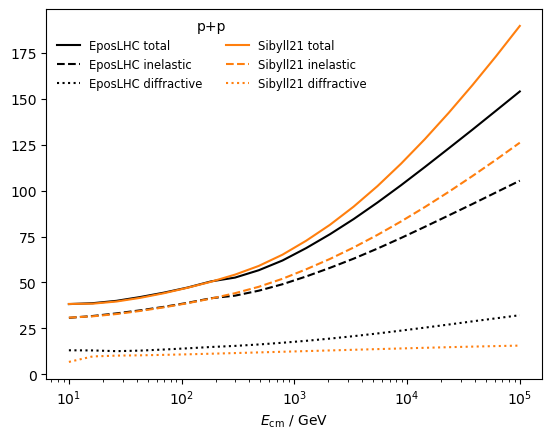

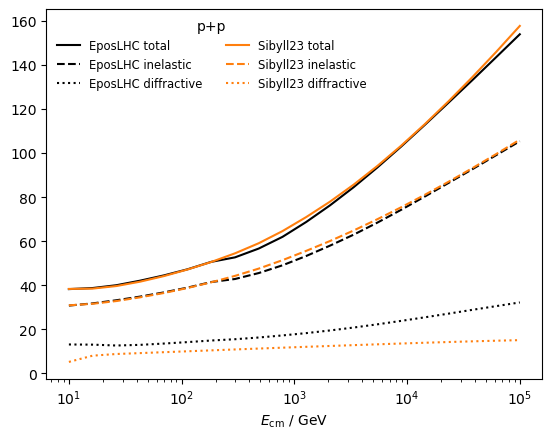

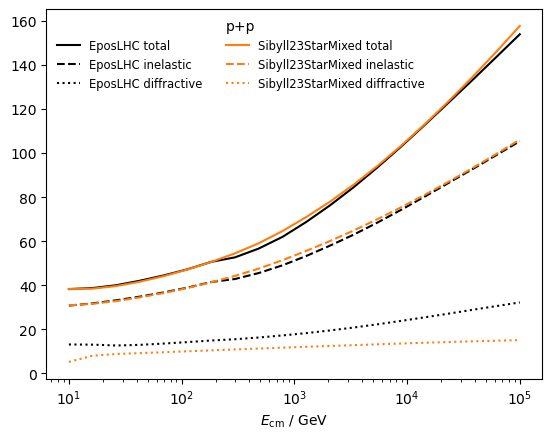

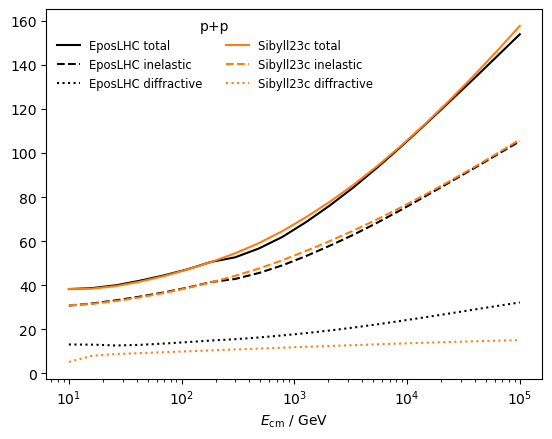

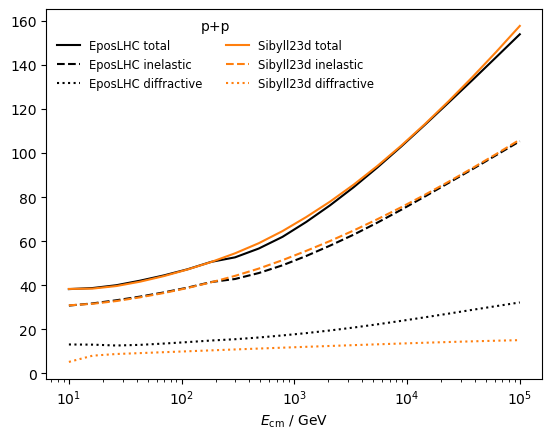

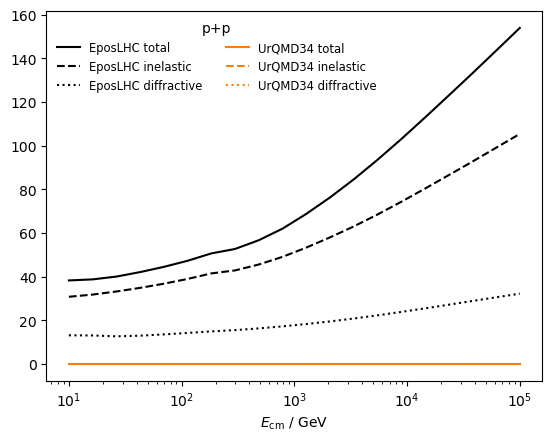

In [3]:
import dataclasses

reference_model = "EposLHC"

for model in cross_sections:
    if model == reference_model:
        continue
    plt.figure()
    kinds = "total", "inelastic", "diffractive"
    for k, model2 in enumerate((reference_model, model)):
        data = cross_sections[model2]
        for i, kind in enumerate(kinds):
            val = [getattr(d, kind) for d in data]

            if np.any(val != 0):
                plt.plot(
                    energies / GeV,
                    val,
                    label=model2 + " " + kind,
                    ls=["-", "--", ":"][i],
                    color=["k", "C1"][k],
                    zorder=1 + k,
                )
    plt.semilogx()
    plt.legend(frameon=False, ncol=2, fontsize="small", title="p+p")
    plt.xlabel("$E_\\mathrm{cm}$ / GeV")